# Flower Feature Localization with Grad-CAM

In [152]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
import random
from random import shuffle 
import collections
import io
import math

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras 

In [2]:
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.resnet import ResNet50
from keras.applications.inception_v3 import InceptionV3

from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
from keras.layers import Dropout, Input, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

## Data Preparation

In [86]:
FLOWERS_DIR ='dataset/FlowerData-30'

# path = '/content/drive/Shareddrives/Visual Information Processing/'
# FLOWERS_DIR = path + 'Annotated-FlowerData-30'

# from google.colab import drive
# drive.mount('/content/drive')

In [87]:
H, W = 224, 224
BATCH_SIZE = 64
EPOCHS = 100

TRAIN_FRACTION = 80
RANDOM_SEED = 2018

In [88]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    FLOWERS_DIR,
    target_size=(H, W),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=RANDOM_SEED
)

validation_generator = test_datagen.flow_from_directory(
    FLOWERS_DIR,
    target_size=(H, W),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=RANDOM_SEED
)

Found 1982 images belonging to 30 classes.
Found 491 images belonging to 30 classes.


In [89]:
for image_batch, label_batch in validation_generator:
    break
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 30))

In [90]:
print(train_generator.class_indices)

{'Artichoke': 0, 'Azalea': 1, 'Bearded Iris': 2, 'Bird of Paradise': 3, 'Bluebell': 4, 'Bromelia': 5, 'Buttecup': 6, 'Camellia': 7, 'Canna Lily': 8, 'Colts_Foot': 9, 'Columbine': 10, 'Cowslip': 11, 'Crocus': 12, 'Daffodil': 13, 'Daisy': 14, 'Dandelion': 15, 'Fritillary': 16, 'LilyValley': 17, 'Mexican Petunia': 18, 'Pansy': 19, 'Peruvian Lily': 20, 'Poinsettia': 21, 'Purple Coneflower': 22, 'Snapdragon': 23, 'Snowdrop': 24, 'Sunflower': 25, 'Sweet William': 26, 'Tigerlily': 27, 'Tulip': 28, 'Windflower': 29}


In [91]:
# saving labels to txt file
labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
    f.write(labels)
    
print('done!')

done!


In [92]:
save_path = 'labels.txt'
label = np.array(open(save_path).read().splitlines())

## MobileNetV2, ResNet50 and InceptionV3

We trained 3 types of convolutional neural networks, which are MobileNetV2, ResNet50 and InceptionV3. The training process for all three networks are available in separate Jupyter notebooks.

MobileNetV2: `FL-MobileNetV2.ipynb`  
ResNet50: `FL-ResNet50.ipynb`  
InceptionV3: `FL-InceptionV3.ipynb`

### Loading the Pre-Trained Models

We have a total of 3 CNN models - MobileNetV2, ResNet50 and InceptionV3

In [93]:
from keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [149]:
mobilenet = tf.keras.models.load_model(
    'model/MobileNetV2.h5', 
    custom_objects={
        "precision_m": precision, 
        "recall_m": recall
    }
)

resnet = tf.keras.models.load_model(
    'model/ResNet50.h5', 
    custom_objects={
        "precision_m": precision, 
        "recall_m": recall
    }
)

inception = tf.keras.models.load_model(
    'model/InceptionV3.h5', 
    custom_objects={
        "precision_m": precision, 
        "recall_m": recall
    }
)

### Checking Accuracy

In [150]:
# Function to load image
def load_image(img_path, show=False, title=None):

    img = image.load_img(img_path, target_size=(H, W))
    img_tensor = image.img_to_array(img) # (height, width, channels)
            
    # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0) 
    
    img_tensor /= 255. # imshow expects values in the range [0, 1]
    plt.title(title)
    
    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()
    
    # return image for prediction
    return img_tensor

# Function to show top x predicitons of the model
def pred_result(pred, show_top=3):
    
    top_results = np.argsort(pred[0])[-show_top:][::-1]
    prediction = []
    
    for i in top_results:
        prediction.append([label[i], "{:.5f}".format(pred[0][i])])
    
    df = pd.DataFrame(prediction, columns = ['flower', 'probability'])
    display(df)

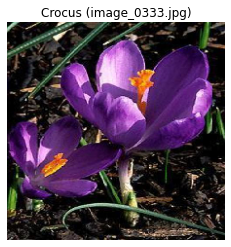


===== MobileNetV2 =====


,flower,probability
0,Crocus,0.92190
1,Camellia,0.02700
2,Bearded Iris,0.01597



====== ResNet50 =======


,flower,probability
0,Poinsettia,0.17838
1,Crocus,0.15600
2,Daisy,0.08839



===== InceptionV3 =====


,flower,probability
0,Crocus,0.99867
1,Bearded Iris,0.00077
2,Snapdragon,0.00030


In [156]:
# load a random image from our dataset
random_flower = random.choice(os.listdir(FLOWERS_DIR))
random_image = random.choice(os.listdir(FLOWERS_DIR+'/'+random_flower))
image_path = FLOWERS_DIR+'/'+random_flower+'/'+random_image

title = f'{random_flower} ({random_image})'
flower_image = load_image(image_path, show=True, title=title)

print('\n===== MobileNetV2 =====')
pred_m = mobilenet.predict(flower_image)
pred_result(pred_m, show_top=3)

print('\n====== ResNet50 =======')
pred_r = resnet.predict(flower_image)
pred_result(pred_r, show_top=3)

print('\n===== InceptionV3 =====')
pred_i = inception.predict(flower_image)
pred_result(pred_i, show_top=3)

ResNet50 is underperforming.

## Grad-CAM

In [97]:
def GradCam(model, img_array, layer_name, eps=1e-8):
    
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model
    

    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str


    Returns 
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = Model(
            inputs=[model.inputs],
            outputs=[model.get_layer(layer_name).output,
                model.output])
    
    with tf.GradientTape() as tape:
        # cast the image tensor to a float-32 data type, pass the
        # image through the gradient model, and grab the loss
        # associated with the specific class index
        inputs = tf.cast(img_array, tf.float32)
        (convOutputs, predictions) = gradModel(inputs)
        loss = predictions[:, 0]
        # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    
    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    
    # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize
    # the output class activation map to match the input image
    # dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
        
    # normalize the heatmap such that all values lie in the range
    # [0, 1], scale the resulting values to the range [0, 255],
    # and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    
    return heatmap


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):
    
    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
    

    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
    
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

### Using Grad-CAM to interpret the result

Bromelia
image_07833.jpg
dataset/FlowerData-30/Bromelia/image_07833.jpg


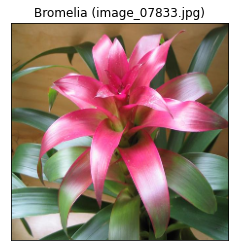

In [189]:
# choose a random flower
random_flower = random.choice(os.listdir(FLOWERS_DIR))
random_image = random.choice(os.listdir(FLOWERS_DIR+'/'+random_flower))
image_path = FLOWERS_DIR+'/'+random_flower+'/'+random_image

print(random_flower)
print(random_image)
print(image_path)

title = f'{random_flower} ({random_image})'
img = cv2.imread(image_path)
img = cv2.resize(img,(224,224)) 


plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(title), plt.xticks([]), plt.yticks([])
plt.show()

#### MobileNetV2

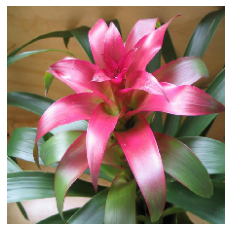

,flower,probability
0,Bromelia,0.99999
1,Tulip,0.00000
2,Columbine,0.00000


In [219]:
flower = load_image(image_path, True)
pred_m = mobilenet.predict(flower)
pred_result(pred_m, show_top=3)

In [98]:
mobilenet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_14[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

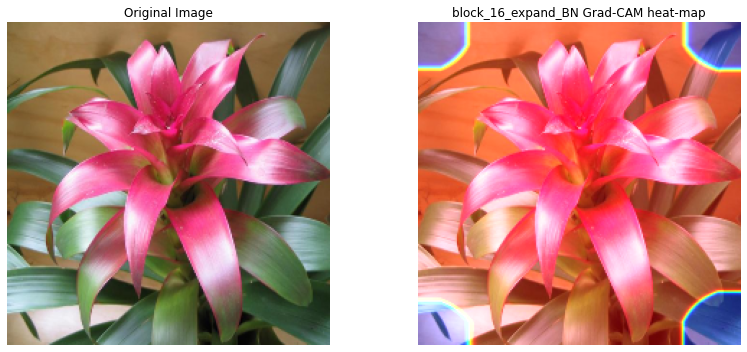

In [190]:
layer_name = 'block_16_expand_BN' # last mobilenet layer

grad_cam = GradCam(mobilenet, np.expand_dims(img, axis=0), layer_name)
grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=True)

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title(f'{layer_name} Grad-CAM heat-map')
plt.tight_layout()

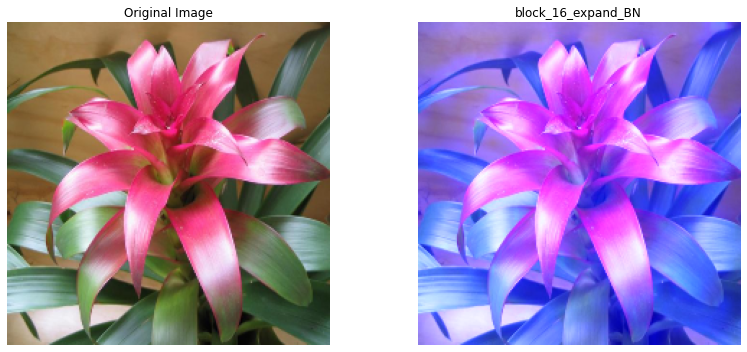

In [191]:
plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
grad_cam = GradCam(mobilenet, np.expand_dims(img, axis=0), 'block_4_expand_relu')
grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=False)
plt.imshow(grad_cam_emphasized)
plt.axis('off')
plt.title(f'{layer_name}')
plt.tight_layout()


In [177]:
## Gather all convolution and activation layers from the model
## With these layers, we can explore grad-cam heatmaps for more layers in the model

def get_layers(model):
    conv2D_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.Conv2D)]
    activation_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and layer.__class__.__name__ == 'ReLU']
    all_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and (layer.__class__.__name__ == 'ReLU' or isinstance(layer, tf.keras.layers.Conv2D))]
    
    return conv2D_layers, activation_layers, all_layers


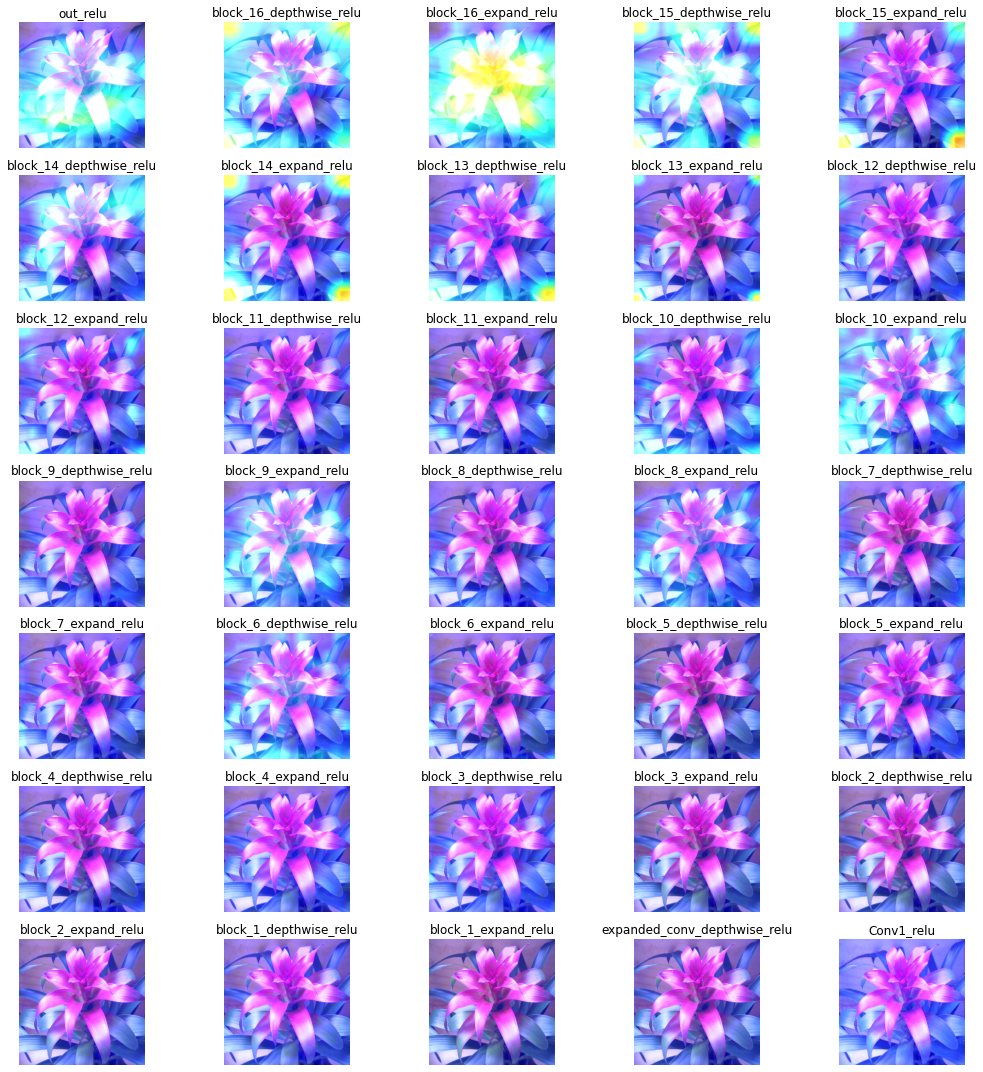

In [192]:
conv2D_layers, activation_layers, all_layers = get_layers(mobilenet)

## Visualizing Activation layers
plt.figure(figsize=(15, 15))
for i, layer in enumerate(activation_layers):
    grad_cam = GradCam(mobilenet, np.expand_dims(img, axis=0), layer)
    grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=False)
    ax = plt.subplot(7, 5, i +1)
    plt.imshow(grad_cam_emphasized)
    plt.title(layer)
    plt.axis("off")
plt.tight_layout()


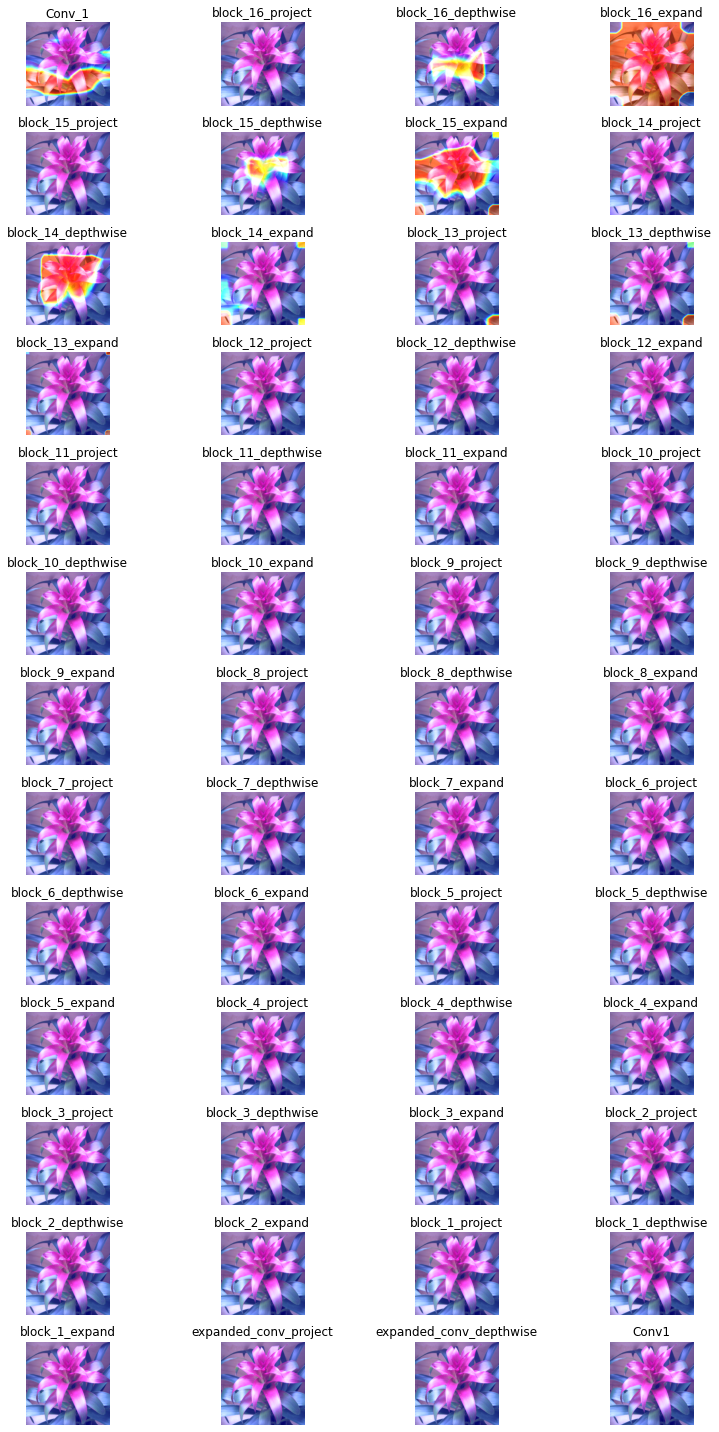

In [193]:
## Visualizing Convolution layers
plt.figure(figsize=(12, 20))
for i, layer in enumerate(conv2D_layers):
    grad_cam = GradCam(mobilenet, np.expand_dims(img, axis=0), layer)
    grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=True)
    ax = plt.subplot(13, 4, i +1)
    plt.imshow(grad_cam_emphasized)
    plt.title(layer)
    plt.axis("off")
plt.tight_layout()

In [139]:
def fuse_layers(layers, model, img, emphasize=False):
    '''
    Fuses grad-cam heatmaps from a list of model layers into a single heatmap
    and superimposes the heatmap onto an image.

    Args:
        layers: list of strings
        model: tf model
        img: (img_width x img_height x 3) numpy array


    Returns 
        uint8 numpy array with shape (img_height, img_width, 3)

    '''
    cams = []
    for layer in layers:
        cam = GradCam(model, np.expand_dims(img, axis=0), layer)
        cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
        cams.append(cam)

    fused = np.mean(cams, axis=0)
    superimposed = superimpose(img, fused, 0.5, emphasize=emphasize)

    return superimposed


Text(0.5, 1.0, 'All layers Grad-CAM heat-map')

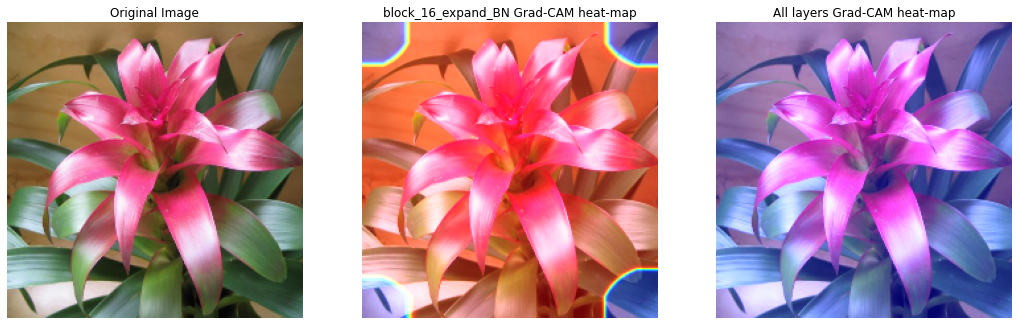

In [194]:
## Using the fuse_layers function, lets fuse together all layers in the model

fused = fuse_layers(all_layers, mobilenet, img, True)

## We can see how fusing together all layers improves upon the Grad-CAM from the last
## convolutional layer in the model

plt.figure(figsize=(18, 8))
ax = plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 3, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title(f'{layer_name} Grad-CAM heat-map')
ax = plt.subplot(1, 3, 3)
plt.imshow(fused)
plt.axis('off')
plt.title('All layers Grad-CAM heat-map')